In [ ]:
import tensorflow as tf

tf.enable_eager_execution()
tf.executing_eagerly()

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Reshape, Conv2D, Input, MaxPooling2D, BatchNormalization, Dense, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNet
import numpy as np
from utils import read_labels, draw_image, image_to_yolo_input, Object, parse_annotation, Annotation, calculate_IoU, image_to_vgg_input, image_to_mobilenet_input, LabelEncoder
from PIL import Image as Img
import os
import matplotlib.pyplot as plt

In [586]:
#TODO: read from config

image_width = 416
image_height = 416
grid_width = int(image_width / 32) # 13
grid_height = int(image_height / 32) # 13

cell_width = image_width / grid_width
cell_height = image_height / grid_height

boxes = 5

activation_alpha = 0.1

object_scale = 10
noobject_scale = 1
class_scale = 2
coord_scale = 2

threshhold = 0.5
nms_threshhold = 0.5#0.5

anchors = np.array([[1.05, 1.65], [2.44, 4.13], [4.01, 8.46], [7.62, 5.13], [9.97, 10.43]], dtype = np.float32) # obtained from KMeans experiments ipynb

batch_size = 125

labels_dir = "./labels.txt"

annotation_folder = '.\VOCdevkit\VOC2007\Annotations'
images_folder = '.\VOCdevkit\VOC2007\JPEGImages'

murka = r'.\mytestimages\murka.jpg'

test_annotation = r'.\VOCdevkit\VOC2007\Annotations\000113.xml'
test_image = r'.\VOCdevkit\VOC2007\JPEGImages\000113.jpg'

In [ ]:
labels, labels_count = read_labels(labels_dir)

encoder = LabelEncoder(labels)
#labels_count = 0 # TODO: remove when implementing classification

print(labels_count)
print(labels)

In [ ]:
def get_tinyyolov2():
    layers = []

    layers.append(Input(shape=(image_width, image_height, 3)))

    layers.append(Conv2D(filters = 16, kernel_size = (3, 3), padding = "same", use_bias = False, name="conv_1"))
    layers.append(BatchNormalization(name = "norm_1"))
    layers.append(LeakyReLU(name = "leaky_1", alpha = activation_alpha))
    layers.append(MaxPooling2D(name = "maxpool_1"))

    layers.append(Conv2D(filters = 32, kernel_size = (3, 3), padding = "same", use_bias = False, name="conv_2"))
    layers.append(BatchNormalization(name = "norm_2"))
    layers.append(LeakyReLU(name = "leaky_2", alpha = activation_alpha))
    layers.append(MaxPooling2D(name = "maxpool_2"))

    layers.append(Conv2D(filters = 64, kernel_size = (3, 3), padding = "same", use_bias = False, name="conv_3"))
    layers.append(BatchNormalization(name = "norm_3"))
    layers.append(LeakyReLU(name = "leaky_3", alpha = activation_alpha))
    layers.append(MaxPooling2D(name = "maxpool_3"))

    layers.append(Conv2D(filters = 128, kernel_size = (3, 3), padding = "same", use_bias = False, name="conv_4"))
    layers.append(BatchNormalization(name = "norm_4"))
    layers.append(LeakyReLU(name = "leaky_4", alpha = activation_alpha))
    layers.append(MaxPooling2D(name = "maxpool_4"))

    layers.append(Conv2D(filters = 256, kernel_size = (3, 3), padding = "same", use_bias = False, name="conv_5"))
    layers.append(BatchNormalization(name = "norm_5"))
    layers.append(LeakyReLU(name = "leaky_5", alpha = activation_alpha))
    layers.append(MaxPooling2D(name = "maxpool_5"))

    layers.append(Conv2D(filters = 512, kernel_size = (3, 3), padding = "same", use_bias = False, name="conv_6"))
    layers.append(BatchNormalization(name = "norm_6"))
    layers.append(LeakyReLU(name = "leaky_6", alpha = activation_alpha))
    #layers.append(MaxPooling2D(name = "maxpool_6", pool_size = (2, 2), strides = (1, 1)))

    layers.append(Conv2D(filters = 1024, kernel_size = (3, 3), padding = "same", use_bias = False, name="conv_7"))
    layers.append(BatchNormalization(name = "norm_7"))
    layers.append(LeakyReLU(name = "leaky_7", alpha = activation_alpha))

    layers.append(Conv2D(filters = 1024, kernel_size = (3, 3), padding = "same", use_bias = False, name="conv_8"))
    layers.append(BatchNormalization(name = "norm_8"))
    layers.append(LeakyReLU(name = "leaky_8", alpha = activation_alpha))

    layers.append(Conv2D(filters = (boxes * (4 + 1 + labels_count)), kernel_size = (1, 1), padding = "same", name="conv_9"))

    layers.append(Reshape(target_shape = (grid_width, grid_height, boxes, 5 + labels_count), name = "output"))

    tinyyolov2 = Sequential(layers = layers, name = "tiny yolov2 voc")
    tinyyolov2.summary()
    
    return tinyyolov2

In [ ]:
def get_annotations_images(annotations_dir, images_dir):
    image_formats = ['.png', '.jpg', '.jpeg', '.tiff', '.bmp', '.gif']
    
    annons, images = [], []
    # r=root, d=directories, f = files
    for r, d, f in os.walk(annotations_dir):
        for file in f:
            if '.xml' in file:
                image_exists = False
                for im_format in image_formats:
                    image_name = file[:-4] + im_format
                   
                    image_path = images_dir + '\\' + image_name
                    
                    if os.path.exists(image_path):
                        image_exists = True
                        break
                        
                if image_exists:
                    annons.append(annotations_dir + '\\' + file)
                    images.append(images_dir + '\\' + image_name)
    
    annons = annons[:250]
    images = images[:250]
    
    return annons, images

In [ ]:
def encode_y_true_from_annotatoin(annotation):    
    y_true = np.zeros(shape = (grid_width, grid_height, boxes, 5 + labels_count))
    objs = [[[] for col in range(grid_width)] for row in range(grid_height)]
    
    annotation = parse_annotation(annotation)
    
    image_cell_width = annotation.imagewidth / grid_width
    image_cell_height = annotation.imageheight / grid_height
    
    for obj in annotation.objects:
        obj.xmid = (obj.xmax + obj.xmin) / 2
        obj.ymid = (obj.ymax + obj.ymin) / 2
        obj.width = obj.xmax - obj.xmin
        obj.height = obj.ymax - obj.ymin

        row = int(obj.ymid / image_cell_height)
        col = int(obj.xmid / image_cell_width)
        #print(f'row {row} col {col}')
        
        objs[row][col].append(obj)        
    
        best_anchor_index = 0
        best_IoU = -1
        
        for index in range(boxes):
            anchor_w, anchor_h = anchors[index]
            #print(f'anchor_w: {anchor_w}, cell_width: {image_cell_width}, width: {anchor_w * image_cell_width}')
            #print(f'anchor_h: {anchor_h}, cell_height: {image_cell_height}, height: {anchor_h * image_cell_height}')
            
            width = anchor_w * image_cell_width
            height = anchor_h * image_cell_height
            
            xmid = (col + 0.5) * image_cell_width
            ymid = (row + 0.5) * image_cell_height
            
            anchor_object = Object(xmin = xmid - width/2, xmax = xmid + width/2, ymin = ymid - height/2, ymax = ymid + height/2)
            #print(anchor_object)
            
            current_IoU = calculate_IoU(obj, anchor_object)
            #print(f'IoU: {current_IoU}')
            #draw_image(images_folder + '\\'  + annotation.filename[:-4] + '.jpg', objects = [obj, anchor_object], draw_grid = True, grid_size = (grid_width, grid_height))
            if current_IoU > best_IoU:
                best_IoU = current_IoU
                best_anchor_index = index
                  
            
        
        '''
        grid_center_x = (row + 0.5) * image_cell_width
        grid_center_y = (col + 0.5) * image_cell_height
        
        x = obj.xmid - grid_center_x
        y = obj.ymid - grid_center_y
        
        w = np.log(obj.width / anchors[best_anchor_index][0]) 
        h = np.log(obj.height / anchors[best_anchor_index][1]) 
        '''      
        x = obj.xmid
        y = obj.ymid
        
        w = obj.width
        h = obj.height
        
        c = 1 #best_IoU
        
        detector = np.zeros(shape=(5 + labels_count))
        
        detector[0] = c
        detector[1] = x
        detector[2] = y
        detector[3] = w
        detector[4] = h
        
        label_index = encoder.encode(obj.name)        
        detector[5 + label_index] = 1
        
        
        y_true[row][col][best_anchor_index] = detector
    
    
    return y_true

In [ ]:
assume_batch_size = 10
assume_grid_width = 3
assume_grid_height = 3
assume_boxes = 2

cell_x = np.reshape(np.repeat(np.tile(range(assume_grid_width), assume_batch_size * assume_grid_height), assume_boxes), (assume_batch_size, assume_grid_width, assume_grid_height, assume_boxes))
cell_y = np.transpose(cell_x, (0,2,1,3))

#print(cell_y.shape)
#print(cell_y)
#print('=====================================')
#print(cell_index)

cell_x = tf.to_float(tf.reshape(tf.keras.backend.repeat_elements(tf.tile(tf.range(assume_grid_width), [assume_batch_size * assume_grid_height]), assume_boxes, axis=0), 
                        (assume_batch_size, assume_grid_width, assume_grid_height, assume_boxes)))
cell_y = tf.transpose(cell_x, (0,2,1,3))

#print(cell_x)
#print('=====================================')
#print(cell_y)

In [ ]:
    '''
    intermins = tf.maximum(xy_true, xy_pred)
    intermaxes = tf.minimum(xy_true, xy_pred)

    interArea = tf.maximum(0.0, intermaxes[..., 0] - intermins[..., 0] + 1) * tf.maximum(0.0, intermaxes[..., 1] - intermins[..., 1] + 1)

    groundTruthArea = (wh_true[..., 0] + 1) * (wh_true[..., 1] + 1)
    predictedArea = (wh_pred[..., 0] + 1) * (wh_pred[..., 1] + 1)

    iou = interArea / (groundTruthArea + predictedArea - interArea)    
    
    xpred = y_pred[:, :, :, :, 1]   
    ypred = y_pred[:, :, :, :, 2]                
    xtrue = y_true[:, :, :, :, 1]
    ytrue = y_true[:, :, :, :, 2]

    wpred = y_pred[:, :, :, :, 3]
    hpred = y_pred[:, :, :, :, 4]                
    wtrue = y_true[:, :, :, :, 3]
    htrue = y_true[:, :, :, :, 4]

    xy_pred = y_pred[:, :, :, :, 1 : 3]
    xy_true = y_true[:, :, :, :, 1 : 3]

    wh_pred = y_pred[:, :, :, :, 3 : 5]
    wh_true = y_true[:, :, :, :, 3 : 5]
    '''   
    
    
    #loss = tf.reduce_mean(loss)
    #print(np.any(np.isnan(xywhcoef)))
    #print(np.any(np.isnan(((xtrue - xpred) ** 2))))
    #print(np.any(np.isnan(xywhcoef * ((xtrue - xpred) ** 2))))
    #print(loss)
    

'''
def custom_loss(y_true, y_pred):
    c_pred = tf.sigmoid(y_pred[:, :, :, :, 0])
    c_true = y_true[:, :, :, :, 0]
    
    greaters = tf.greater(c_true, 0.0)
    
    mask_shape = (batch_size, grid_width, grid_height, boxes)
    objs = tf.ones(shape = (mask_shape)) * object_scale
    noobjs = tf.ones(shape = (mask_shape)) * noobject_scale
    
    coef = tf.where(greaters, objs, noobjs) 
    
    
    
    return coef * (c_true - c_pred) ** 2
'''


#runningman = images[52]
#runningmanannot = annotations[52]

In [ ]:
#print(np.array(anchors)[:, 0])

In [ ]:
# (almost) complete yolov2 loss function
def custom_loss(y_true, y_pred):    
    c_pred = y_pred[:, :, :, :, 0]
    c_true = y_true[:, :, :, :, 0]
    
    c_pred = tf.sigmoid(c_pred)
    
    cell_x = tf.to_float(tf.reshape(tf.keras.backend.repeat_elements(
                                                tf.tile(tf.range(grid_width), [batch_size * grid_height]), boxes, axis=0), 
                                    (batch_size, grid_width, grid_height, boxes)))
    cell_y = tf.transpose(cell_x, (0,2,1,3))
    
    
    xpred = y_pred[:, :, :, :, 1]
    ypred = y_pred[:, :, :, :, 2]
    wpred = y_pred[:, :, :, :, 3]
    hpred = y_pred[:, :, :, :, 4]
    
    box_xpred = (tf.sigmoid(xpred) + cell_x) * cell_width
    box_ypred = (tf.sigmoid(ypred) + cell_y) * cell_height
    box_wpred = tf.exp(wpred) * anchors[:, 0] * cell_width
    box_hpred = tf.exp(hpred) * anchors[:, 1] * cell_height
    
    
    box_wpredhalf = box_wpred / 2
    box_hpredhalf = box_hpred / 2
    
    box_xpredmin = box_xpred - box_wpredhalf
    box_xpredmax = box_xpred + box_wpredhalf
    box_ypredmin = box_ypred - box_hpredhalf
    box_ypredmax = box_ypred + box_hpredhalf
    
    
    box_xtrue = y_true[:, :, :, :, 1]
    box_ytrue = y_true[:, :, :, :, 2]
    box_wtrue = y_true[:, :, :, :, 3]
    box_htrue = y_true[:, :, :, :, 4]
    
    box_wtruehalf = box_wtrue / 2
    box_htruehalf = box_htrue / 2
    
    box_xtruemin = box_xtrue - box_wtruehalf
    box_xtruemax = box_xtrue + box_wtruehalf
    box_ytruemin = box_ytrue - box_htruehalf
    box_ytruemax = box_ytrue + box_htruehalf
    
    interxmins = tf.maximum(box_xpredmin, box_xtruemin)
    interymins = tf.maximum(box_ypredmin, box_ytruemin)
    interxmaxes = tf.minimum(box_xpredmax, box_xtruemax)
    interymaxes = tf.minimum(box_ypredmax, box_ytruemax)
    
    interareas = tf.maximum(0.0, interxmaxes - interxmins + 1) * tf.maximum(0.0, interymaxes - interymins + 1)
    
    trueareas = (box_htrue + 1) * (box_wtrue + 1)
    predareas = (box_hpred + 1) * (box_wpred + 1)
    
    ious = interareas / (trueareas + predareas - interareas)
    
    mask_shape = (batch_size, grid_width, grid_height, boxes)
    
    objs = tf.ones(shape = (mask_shape)) * object_scale
    noobjs = tf.ones(shape = (mask_shape)) * noobject_scale
    coords = tf.ones(shape = (mask_shape)) * coord_scale
    classes = tf.ones(shape = (mask_shape)) * class_scale
    zeros = tf.zeros(shape = (mask_shape))
    
    objects_present = tf.greater(c_true, 0.0) 
    confcoef = tf.where(objects_present, objs, noobjs)                
    coordcoef = tf.where(objects_present, coords, zeros)
    classescoef = tf.where(objects_present, classes, zeros) 
    
    
    xtrue = box_xtrue / cell_width - (cell_x + 0.5)
    ytrue = box_ytrue / cell_height - (cell_y + 0.5)
    wtrue = tf.log(box_wtrue / (cell_width * anchors[:, 0]))
    htrue = tf.log(box_htrue / (cell_height * anchors[:, 1]))
    
    
    wtrue = tf.where(objects_present, wtrue, zeros)
    htrue = tf.where(objects_present, htrue, zeros)
    ious = tf.where(objects_present, ious, zeros)
       
        
    classestrue = tf.argmax(y_true[:, :, :, :, 5:], -1)
    classespred = tf.nn.softmax(y_pred[:, :, :, :, 5:])
    
    classesloss = classescoef * tf.nn.sparse_softmax_cross_entropy_with_logits(labels=classestrue, logits=classespred)
    
    
    confloss = confcoef * ((ious - c_pred) ** 2)
    
    xloss = coordcoef * ((xtrue - xpred) ** 2)
    yloss = coordcoef * ((ytrue - ypred) ** 2)
    
    wloss = coordcoef * ((wtrue - wpred) ** 2)
    hloss = coordcoef * ((htrue - hpred) ** 2)
    
    coordloss = xloss + yloss + wloss + hloss
    
    
    
    loss = confloss + coordloss + classesloss  
    
    return loss

In [587]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

def decode_prediction(y_pred, onlyconf = False):
    objects = []
    accepted = 0
    rejected = 0
    
    for row in range(grid_height):
        for col in range(grid_width):
            for box in range(boxes):
                to, tx, ty, tw, th = y_pred[row, col, box, :5]
                
                
                conf = sigmoid(to)           
                               
                #if conf >= threshhold and row == 3 and col == 3:
                if conf >= threshhold:
                    labels = y_pred[row, col, box, 5:]
                    labels = softmax(labels)
                    
                    max_label = max(labels)
                    max_index = -1
                    for i in range(len(labels)):
                        if labels[i] == max_label:
                            max_index = i
                            break
                    
                    conf *= labels[max_index]
                    if conf < threshhold:
                        break
                    
                    label = encoder.decode(max_index)
                    accepted+=1
                    #print(f'row: {row} col: {col} box: {box}')
                    if onlyconf:
                        bx = (col + 0.5) * cell_width
                        by = (row + 0.5) * cell_height

                        pw, ph = anchors[box]

                        bw = pw * cell_width
                        bh = ph * cell_height

                        #bw *= cell_width
                        #bh *= cell_height
                    else:
                        bx = (sigmoid(tx) + col) * grid_width
                        by = (sigmoid(ty) + row) * grid_width

                        pw, ph = anchors[box]

                        bw = pw * np.exp(tw)
                        bh = ph * np.exp(tw)

                        bw *= cell_width
                        bh *= cell_height
                    
                    objects.append(Object(xmin = bx - bw/2, xmax = bx + bw/2, ymin = by - bh/2, ymax = by + bh/2, conf = conf, name = label))
                else:
                    rejected+=1
                    
    print(f'accepted: {accepted}, rejected: {rejected}')
    return objects


def nms(objects):
    if len(objects) == 0:
        return []
    
    objects = sorted(objects, key = lambda obj: obj.conf, reverse = True)
    
    result = [objects[0]]
    del objects[0]
    
    for i, obj in enumerate(objects):
        for res in result:
            if calculate_IoU(obj, res) > nms_threshhold:
                del objects[i]
                break
        else:
            result.append(obj)
            del objects[i]
    
    return result

def group_nms(objects):
    keys = set(map(lambda obj: obj.name, objects))
    groups = dict()
    
    for key in keys:
        groups[key] = []
    for obj in objects:
        groups[obj.name].append(obj)
    
    result = []
    for key in keys:
        result.extend(nms(groups[key]))        
    
    return result

def feed_forward(model, image_path, draw = False):
    im = Img.open(image_path)
    
    width_scale = im.width / image_width
    height_scale = im.height / image_height 
    
    im = im.resize((image_width, image_height))
    im = np.array(im, np.float32)
    im /= 255
    
    y_pred = model.predict(np.array([im]))[0]
    
    objects = decode_prediction(y_pred, True)
    
    for obj in objects:
              
        
        w = obj.xmax - obj.xmin
        h = obj.ymax - obj.ymin
        #w *= grid_width
        #h *= grid_height
        
        xmid = (obj.xmax - obj.xmin) / 2
        ymid = (obj.ymax - obj.ymin) / 2
        
        #obj.xmin = xmid - w/2
        #obj.xmax = xmid + w/2
        #obj.ymin = ymid - h/2
        #obj.ymax = ymid + h/2
        
        
        
        obj.xmin *= width_scale
        obj.xmax *= width_scale
        obj.ymin *= height_scale
        obj.ymax *= height_scale
        
        
        
        #obj.xmin = obj.xmin * image_cell_width
        #obj.xmax = obj.xmax * image_cell_width
        #obj.ymin = obj.ymin * image_cell_height
        #obj.ymax = obj.ymax * image_cell_height
        
    if draw:
        draw_image(image_path, objects, draw_grid = True, grid_size = (grid_width, grid_height))
    
    return objects

#feed_forward(mobilenetyolov2, runningman)
#feed_forward(tinyyolov2, test_image)

In [ ]:
annotations, images = get_annotations_images(annotation_folder, images_folder)
ins = np.array([image_to_mobilenet_input(image, inputshape = (image_width, image_height)) for image in images], dtype=np.float32)
outs = np.array([encode_y_true_from_annotatoin(annotation) for annotation in annotations], dtype=np.float32)

print(ins.shape)
print(outs.shape)
print('Prepared ins & outs')

In [ ]:
assert not np.any(np.isnan(ins))
assert not np.any(np.isnan(outs))

In [ ]:
def get_mobilenetyolov2():
    mobilenetyolov2 = MobileNet(weights ='imagenet', include_top = False, input_shape=(image_width, image_height, 3))
    mobilenetyolov2.trainable = False
    layers = mobilenetyolov2.layers[:]

    layers.append(Conv2D(filters = (boxes * (4 + 1 + labels_count)), kernel_size = (1, 1), padding = "same", name="conv_output"))
    layers.append(Reshape(target_shape = (grid_width, grid_height, boxes, 5 + labels_count), name = "output"))

    mobilenetyolov2 = Sequential(layers = layers, name = "yolov2 mobilenetv2")
    #mobilenetyolov2.summary()
    
    return mobilenetyolov2

In [ ]:
mobilenetyolov2 = get_mobilenetyolov2()

adam = Adam(lr=0.5e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
mobilenetyolov2.compile(optimizer = adam, loss = custom_loss)

print('Model compiled')

In [ ]:
testbatchins = ins[:batch_size]
testbatchouts = outs[:batch_size]
#testbatchins = np.array([image_to_mobilenet_input(test_image, (image_width, image_height))], dtype=np.float32)
#testbatchouts = np.array([encode_y_true_from_annotatoin(test_annotation)], dtype=np.float32)
    
pred = mobilenetyolov2.predict(testbatchins)
loss = custom_loss(testbatchouts, pred)

assert not np.any(np.isnan(pred))
assert not np.any(np.isnan(loss))

In [ ]:
#mobilenetyolov2.load_weights('./weights/mobilenetyolov2try04catsuccess')

In [ ]:
gen = tf.keras.preprocessing.image.ImageDataGenerator()

epochs = 25000

h = mobilenetyolov2.fit_generator(gen.flow(x = ins, y = outs, batch_size = batch_size), steps_per_epoch = len(ins) // batch_size, epochs = epochs)

In [59]:
#mobilenetyolov2.save_weights('./weights/mobilenetyolov2try04catsuccess')

In [ ]:
#threshhold = 0.5

In [534]:
index = 0

In [634]:
index-=1

accepted: 3, rejected: 839


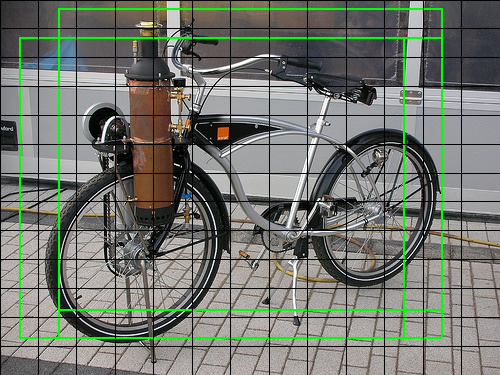

bicycle (0.2140747109999776) (58.26922563406137, 8.221149444580078) (441.7307743659386, 309.08654286311224)
bicycle (0.3561763679161489) (19.80768717252291, 37.067303290733925) (403.26923590440015, 337.93269670926605)
bicycle (0.524106207710199) (58.26922563406137, 37.067303290733925) (441.7307743659386, 337.93269670926605)


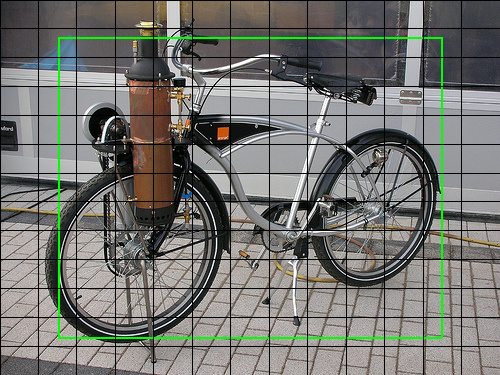

bicycle (0.524106207710199) (58.26922563406137, 37.067303290733925) (441.7307743659386, 337.93269670926605)


In [744]:
threshhold = 0.2
objs = feed_forward(mobilenetyolov2, images[index], True)
for obj in objs:
    print(obj)
objects_trough_nms = group_nms(objs)
draw_image(images[index], objects_trough_nms, draw_grid = True, grid_size = (grid_width, grid_height))
for obj in objects_trough_nms:
    print(obj)
threshhold = 0.5
index += 1

accepted: 7, rejected: 837
person (0.2590970119552955) (-123.36924186119667, 42.09228515624999) (704.9077033996582, 1582.5230994591345)
person (0.7975300516372207) (-123.36924186119667, 189.78459284855768) (704.9077033996582, 1730.2154071514422)
person (0.25247846768985427) (-123.36924186119667, 337.47690054086536) (704.9077033996582, 1877.9077148437498)
person (0.2953312299018502) (-40.29231878427359, 337.47690054086536) (787.9846264765813, 1877.9077148437498)
person (0.2608632643964687) (42.78460429264949, 337.47690054086536) (871.0615495535044, 1877.9077148437498)
person (0.4667586848083454) (125.86152736957257, 337.47690054086536) (954.1384726304275, 1877.9077148437498)
horse (0.4353096514565865) (208.93845044649566, 485.16920823317304) (1037.2153957073506, 2025.6000225360576)


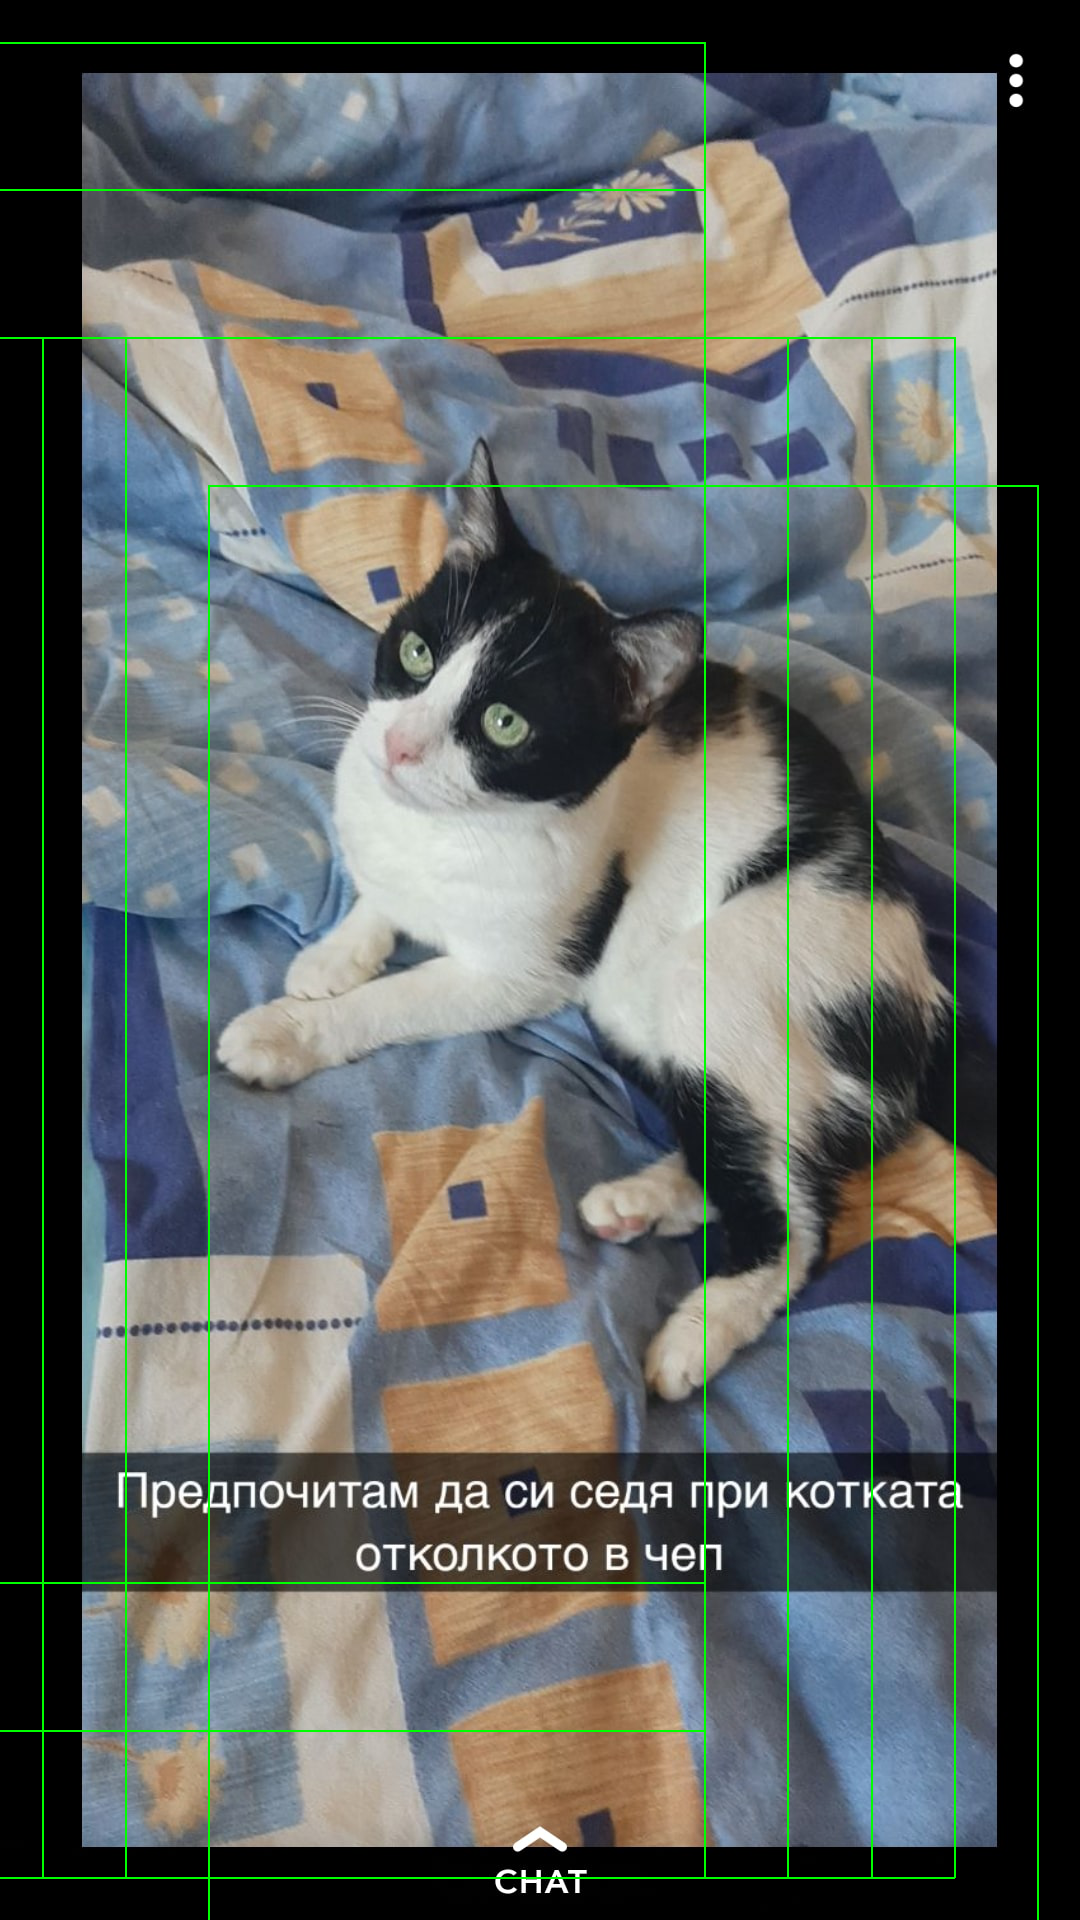

In [732]:
#index = 52
#runningman = images[52]
'''
encoded = encode_y_true_from_annotatoin(annotations[index])
for row in range(grid_width):
    for col in range(grid_height):
        for box in range(boxes):
            if encoded[row, col, box, 0]== 1:
                print(f'{row} {col} {box}')
'''

threshhold = 0.2
objs = feed_forward(mobilenetyolov2, murka, False)
#objs = nms(objs)
for obj in objs:
    print(obj)
draw_image(murka, objs)
threshhold = 0.5

In [ ]:
'''
things to consider:
Lambda layer which decodes output
'''

In [ ]:
'''
TODO:
       
    training:
        what happens when two objects have the same box - pick one at random. better luck next epoch!
        
    possible consideration:
        if the network makes a prediction with an IoU > 0.6 in a detector which was not chosen for the object do not penalise it
      
    image augmentation:
        decide what to do as augmentation
        implement it
    
    
    apply comparing of predicted object type in nms?
    take confidence into consideration nms
    
    train on entire voc 2012 + 2007 not only 2007 and not only 250 images
'''